# Comparative Analysis of Gun Violence Coverage

## Overview
This notebook analyzes how different news outlets (CNN, Fox, NYT, WSJ) portray victims and shooters in gun violence incidents using NLP techniques.

### Tasks
1. Context Extraction with Coreference Resolution
2. Description Extraction
3. Description Clustering
4. Manual Cluster Evaluation
5. Cross-Outlet Frequency Analysis
6. Statistical Hypothesis Testing

In [1]:
# Install dependencies if running on Colab or fresh environment
!pip install spacy fastcoref sentence-transformers pandas numpy matplotlib seaborn scipy transformers huggingface_hub
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import os
# Google Colab Setup
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Mounted Google Drive")

    # Unzip data
    zip_path = "/content/drive/My Drive/Colab Notebooks/NLP HW5/data_100.zip"
    if os.path.exists(zip_path):
        print(f"Found zip at {zip_path}, unzipping...")
        !unzip -q "{zip_path}" -d /content/
        print("Unzipped to /content/data_100")
        colab_data_path = "/content/data_100"
    else:
        print(f"Zip file not found at {zip_path}. Please check path.")
        colab_data_path = None
except ImportError:
    print("Not running on Google Colab.")
    colab_data_path = None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted Google Drive
Found zip at /content/drive/My Drive/Colab Notebooks/NLP HW5/data_100.zip, unzipping...
replace /content/data_100/NYT_five_para/NYT_23_May27.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Unzipped to /content/data_100


In [3]:
import os
import glob
import pandas as pd
import numpy as np
import spacy
import torch
from fastcoref import FCoref
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Task 1: Data Loading & Coreference Resolution

We load the articles and resolve coreferences to replace pronouns with their entities.

In [11]:
def load_articles(data_dir):
    articles = []
    # Traverse directories
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} does not exist.")
        return pd.DataFrame()

    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".txt"):
                path = os.path.join(root, file)
                # Determine outlet from folder name logic
                folder_name = os.path.basename(root).lower()
                outlet = "Other"
                if "cnn" in folder_name: outlet = "CNN"
                elif "fox" in folder_name: outlet = "Fox News"
                elif "nyt" in folder_name: outlet = "NYT"
                elif "wsj" in folder_name: outlet = "WSJ"

                try:
                    with open(path, 'r', encoding='utf-8') as f:
                        text = f.read()
                except UnicodeDecodeError:
                    # Fallback encoding
                    with open(path, 'r', encoding='latin-1') as f:
                        text = f.read()

                articles.append({
                    'outlet': outlet,
                    'filename': file,
                    'text': text
                })
    return pd.DataFrame(articles)

# Determine Data Path
if 'colab_data_path' in globals() and colab_data_path is not None and os.path.exists(colab_data_path):
    data_path = colab_data_path
elif os.path.exists(os.path.join('..', 'data', 'raw')):
    data_path = os.path.join('..', 'data', 'raw')
elif os.path.exists(os.path.join('data', 'raw')):
    data_path = os.path.join('data', 'raw')
else:
    data_path = "./data_100" # Fallback if unzipped locally

print(f"Loading data from {data_path}")
df = load_articles(data_path)
print(f"Loaded {len(df)} articles.")
display(df.groupby('outlet').count())

Loading data from /content/data_100
Loaded 100 articles.


,filename,text
outlet,,
CNN,25,25
Fox News,25,25
NYT,25,25
WSJ,25,25


In [12]:
# Initialize Models
# spaCy for sentence segmentation and basic NLP
try:
    nlp = spacy.load("en_core_web_sm")
except:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# FastCoref for coreference resolution
# Monkeypatch transformers to allow weights_only=False (necessary for this environment/model version)
from transformers import AutoModel, AutoModelForTokenClassification
original_from_pretrained = AutoModel.from_pretrained
original_tc_from_pretrained = AutoModelForTokenClassification.from_pretrained

def unsafe_from_pretrained(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return original_from_pretrained(*args, **kwargs)

def unsafe_tc_from_pretrained(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return original_tc_from_pretrained(*args, **kwargs)

AutoModel.from_pretrained = unsafe_from_pretrained
AutoModelForTokenClassification.from_pretrained = unsafe_tc_from_pretrained

try:
    coref_model = FCoref(device=device)
    print("FastCoref loaded successfully.")
except Exception as e:
    print(f"Warning: FastCoref failed to load ({e}). Using simple fallback.")
    coref_model = None

# Restore original methods to be safe
AutoModel.from_pretrained = original_from_pretrained
AutoModelForTokenClassification.from_pretrained = original_tc_from_pretrained

def resolve_and_extract(text, target_terms_map):
    """
    1. Resolve coreferences in text.
    2. Extract sentences containing terms for each target key.
    target_terms_map: {'shooter': [...], 'victim': [...]}
    """
    # 1. Resolve
    resolved_text = text
    if coref_model:
        try:
            # FastCoref returns a list of predictions
            preds = coref_model.predict(texts=[text])
            resolved_text = preds[0].get_resolved_text()
        except Exception as e:
            # Fallback if prediction fails
            pass

    # 2. Extract Sentences
    doc = nlp(resolved_text)
    extracted = {k: [] for k in target_terms_map}

    for sent in doc.sents:
        sent_lower = sent.text.lower()
        for key, terms in target_terms_map.items():
            # Check if any term is in the sentence
            if any(term in sent_lower for term in terms):
                extracted[key].append(sent.text.strip())

    return resolved_text, extracted

# Define Terms
shooter_terms = ['shooter', 'gunman', 'attacker', 'suspect', 'killer', 'murderer', 'perpetrator']
victim_terms = ['victim', 'killed', 'wounded', 'injured', 'dead', 'casualty', 'survivor', 'student', 'teacher']

term_map = {'shooter': shooter_terms, 'victim': victim_terms}

# Processing Loop
import tqdm

processed_data = []
print("Starting processing... this may take a few minutes.")

for idx, row in df.iterrows():
    try:
        r_text, extracted = resolve_and_extract(row['text'], term_map)

        processed_data.append({
            'outlet': row['outlet'],
            'filename': row['filename'],
            'resolved_text': r_text,
            'shooter_contexts': extracted['shooter'],
            'victim_contexts': extracted['victim']
        })
    except Exception as e:
        print(f"Error processing {row['filename']}: {e}")

processed_df = pd.DataFrame(processed_data)
processed_df.head()

FastCoref loaded successfully.
Starting processing... this may take a few minutes.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

,outlet,filename,resolved_text,shooter_contexts,victim_contexts
0,NYT,NYT_10_May26.txt,Just shy of a decade after the Senate's failur...,[],[]
1,NYT,NYT_19_May26.txt,Rumors about the gunman and what had taken pla...,[Rumors about the gunman and what had taken pl...,[Rumors about the gunman and what had taken pl...
2,NYT,NYT_21_May26.txt,"Xavier Lopez, 10, made the honor roll on the d...","[Xavier's classroom, where a nightmare erupted...","[Xavier Lopez, 10, made the honor roll on the ..."
3,NYT,NYT_8_May26.txt,The massacre in Texas cast a pall over confirm...,[],[That already unpredictable dynamic was upende...
4,NYT,NYT_1_May25.txt,Elizabeth Williamson is the author of ''Sandy ...,[],"[Nearly a decade later, while watching the dea..."


## Task 2: Description Extraction

We use dependency parsing to find adjectives and verbs that describe the target entities.

In [13]:
def extract_descriptors(sentence, target_terms):
    doc = nlp(sentence)
    descriptions = set()

    # Iterate tokens
    for i, token in enumerate(doc):
        # Check if token matches target
        if token.text.lower() in target_terms:

            # Approach A: Dependency Parsing
            # 1. Adjectives modifying the noun (amod)
            for child in token.children:
                if child.dep_ == "amod":
                    descriptions.add(child.text.lower())

            # 2. Predicate adjectives (acomp)
            if token.dep_ == "nsubj":
                head = token.head
                if head.pos_ in ["VERB", "AUX"]:
                    for child in head.children:
                        if child.dep_ == "acomp":
                            descriptions.add(child.text.lower())

            # 3. Actions (verbs) where entity is subject
            if token.dep_ == "nsubj" and token.head.pos_ == "VERB":
                descriptions.add(token.head.text.lower())

            # Approach B: POS-Based Window Extraction (Proximity)
            # Look at +/- 3 tokens for adjectives or verbs we might have missed
            start = max(0, i - 3)
            end = min(len(doc), i + 4)
            for j in range(start, end):
                neighbor = doc[j]
                if neighbor.pos_ in ["ADJ", "VERB"] and neighbor.text.lower() not in target_terms:
                     if not neighbor.is_stop and neighbor.is_alpha:
                        descriptions.add(neighbor.text.lower())

    return list(descriptions)

# Flatten the list for analysis

all_descriptions = []

for idx, row in processed_df.iterrows():
    # Shooter Descriptions
    for sent in row['shooter_contexts']:
        descs = extract_descriptors(sent, shooter_terms)
        for d in descs:
            all_descriptions.append({'term': d, 'outlet': row['outlet'], 'type': 'shooter', 'source_text': sent})

    # Victim Descriptions
    for sent in row['victim_contexts']:
        descs = extract_descriptors(sent, victim_terms)
        for d in descs:
            all_descriptions.append({'term': d, 'outlet': row['outlet'], 'type': 'victim', 'source_text': sent})

desc_df = pd.DataFrame(all_descriptions)
print(f"Extracted {len(desc_df)} descriptions.")
desc_df.head()

Extracted 203 descriptions.


,term,outlet,type,source_text
0,accused,NYT,victim,The two teachers who were killed were also acc...
1,erupted,NYT,shooter,"Xavier's classroom, where a nightmare erupted ..."
2,burst,NYT,shooter,"Xavier's classroom, where a nightmare erupted ..."
3,burst,NYT,victim,"Xavier's classroom, where a nightmare erupted ..."
4,defeated,NYT,victim,"Nearly a decade later, while watching the deat..."


## Task 3: Description Clustering

We embed the extracted description terms and cluster them to find common themes.

In [14]:
# Load Sentence Transformer
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Get unique terms to cluster
unique_terms = desc_df['term'].unique()
print(f"Unique terms to cluster: {len(unique_terms)}")

if len(unique_terms) > 0:
    # Embed
    embeddings = embedder.encode(unique_terms)

    # Dimensionality Reduction for Visualization
    # Perplexity must be < n_samples
    perp = min(30, len(unique_terms)-1) if len(unique_terms) > 1 else 1
    if len(unique_terms) > 2:
        umap_embeds = TSNE(n_components=2, random_state=42, perplexity=perp).fit_transform(embeddings)
    else:
        umap_embeds = np.zeros((len(unique_terms), 2))

    # Clustering - Agglomerative
    from sklearn.cluster import AgglomerativeClustering

    # We lower distance_threshold to split clusters more aggressively
    # 1.0 corresponds to orthogonal in cosine space.
    clusterer = AgglomerativeClustering(n_clusters=None, distance_threshold=0.8, metric='cosine', linkage='average')

    labels = clusterer.fit_predict(embeddings)

    # Map back to dataframe
    term_to_label = dict(zip(unique_terms, labels))
    desc_df['cluster_id'] = desc_df['term'].map(term_to_label)

    print(f"Number of clusters found: {len(set(labels))}")
else:
    print("No terms to cluster.")

Unique terms to cluster: 80
Number of clusters found: 4


## Task 4: Manual Cluster Evaluation

In this section, you should look at the printed clusters and assign them names manually.

In [15]:
# Inspect Clusters
cluster_map = {}
if 'labels' in locals():
    for label in set(labels):
        terms = unique_terms[labels == label]
        if len(terms) < 3: continue # Lower threshold to see smaller clusters
        print(f"Cluster {label}: {terms[:10]}...")

        # Here you would manually assign names.
        # For automation, I'll assign a 'Representative' name based on the most frequent term if possible or just ID.
        cluster_map[label] = f"Cluster_{label}"

    print("\nAssigning names to DataFrame...")
    desc_df['cluster_name'] = desc_df['cluster_id'].map(lambda x: cluster_map.get(x, f"Other_{x}"))

Cluster 0: ['accused' 'erupted' 'burst' 'defeated' 'entered' 'killed' 'barricaded'
 'identified' 'contained' 'responding']...

Assigning names to DataFrame...


## Task 5: Frequency Analysis & Visualization

cluster_name,Cluster_0,Other_1,Other_2,Other_3
outlet,,,,
CNN,52,1,0,0
Fox News,58,0,0,0
NYT,47,0,1,2
WSJ,42,0,0,0


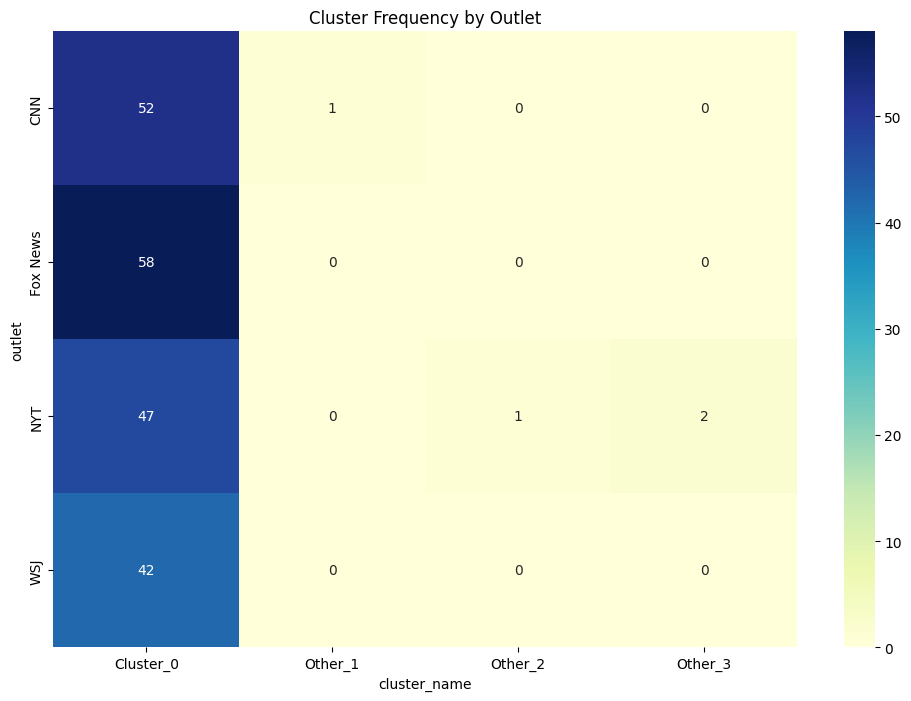

In [16]:
if len(desc_df) > 0:
    # Frequency Table
    freq_table = pd.crosstab(desc_df['outlet'], desc_df['cluster_name'])
    display(freq_table)

    # Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(freq_table, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Cluster Frequency by Outlet')
    plt.show()

## Task 6: Statistical Analysis

In [17]:
# Example Chi-Squared Test for Top 3 Clusters
if len(desc_df) > 0:
    top_clusters = desc_df['cluster_name'].value_counts().head(3).index.tolist()

    for cluster in top_clusters:
        print(f"\nTesting Component: {cluster}")
        # Create contingency table: [Outlet] x [Has_Cluster, Does_Not_Have_Cluster]
        # Note: The assignment asks for proportions of frame use.
        # We can check specific frame vs all other frames.

        contingency = []
        outlets = sorted(desc_df['outlet'].unique())

        for outlet in outlets:
            outlet_descs = desc_df[desc_df['outlet'] == outlet]
            count_in_cluster = len(outlet_descs[outlet_descs['cluster_name'] == cluster])
            count_total = len(outlet_descs)
            count_other = count_total - count_in_cluster

            contingency.append([count_in_cluster, count_other])

        try:
            stat, p, dof, expected = chi2_contingency(contingency)
            print(f"Chi2 Stat: {stat:.4f}, p-value: {p:.4f}")
            if p < 0.05:
                print("Result: Significant difference between outlets.")
            else:
                print("Result: No significant difference.")
        except Exception as e:
            print(f"Could not run test: {e}")


Testing Component: Cluster_0
Chi2 Stat: 6.2150, p-value: 0.1016
Result: No significant difference.

Testing Component: Other_3
Chi2 Stat: 6.1809, p-value: 0.1031
Result: No significant difference.

Testing Component: Other_2
Chi2 Stat: 3.0751, p-value: 0.3802
Result: No significant difference.


In [18]:
# Save Results to CSV
if len(processed_df) > 0:
    processed_df.to_csv('processed_articles_resolved.csv', index=False)
    print("Saved processed_articles_resolved.csv")

if len(desc_df) > 0:
    desc_df.to_csv('labeled_clusters.csv', index=False)
    print("Saved labeled_clusters.csv")

Saved processed_articles_resolved.csv
Saved labeled_clusters.csv
